In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/data-prep-assignment


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/data-prep-assignment


In [17]:
# Import necessary libraries
import os
import librosa.display
import matplotlib.pyplot as plt

# Mount Google Drive (assuming your dataset is stored there)
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset
path = 'emotional-speech-audio/'

# List all files in the dataset
file_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            file_paths.append(os.path.join(root, file))

# Print basic information about the dataset
print(f'Total number of audio files: {len(file_paths)}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total number of audio files: 1440


{'Modality': '03', 'Vocal Channel': '01', 'Emotion': '05', 'Emotional Intensity': '01', 'Statement': '02', 'Repetition': '01', 'Actor': '06'}
{'Modality': '03', 'Vocal Channel': '01', 'Emotion': '04', 'Emotional Intensity': '02', 'Statement': '01', 'Repetition': '01', 'Actor': '06'}
{'Modality': '03', 'Vocal Channel': '01', 'Emotion': '05', 'Emotional Intensity': '01', 'Statement': '01', 'Repetition': '01', 'Actor': '06'}
{'Modality': '03', 'Vocal Channel': '01', 'Emotion': '01', 'Emotional Intensity': '01', 'Statement': '01', 'Repetition': '01', 'Actor': '06'}
{'Modality': '03', 'Vocal Channel': '01', 'Emotion': '03', 'Emotional Intensity': '02', 'Statement': '02', 'Repetition': '01', 'Actor': '06'}


<ipython-input-18-492447f7d032>:32: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


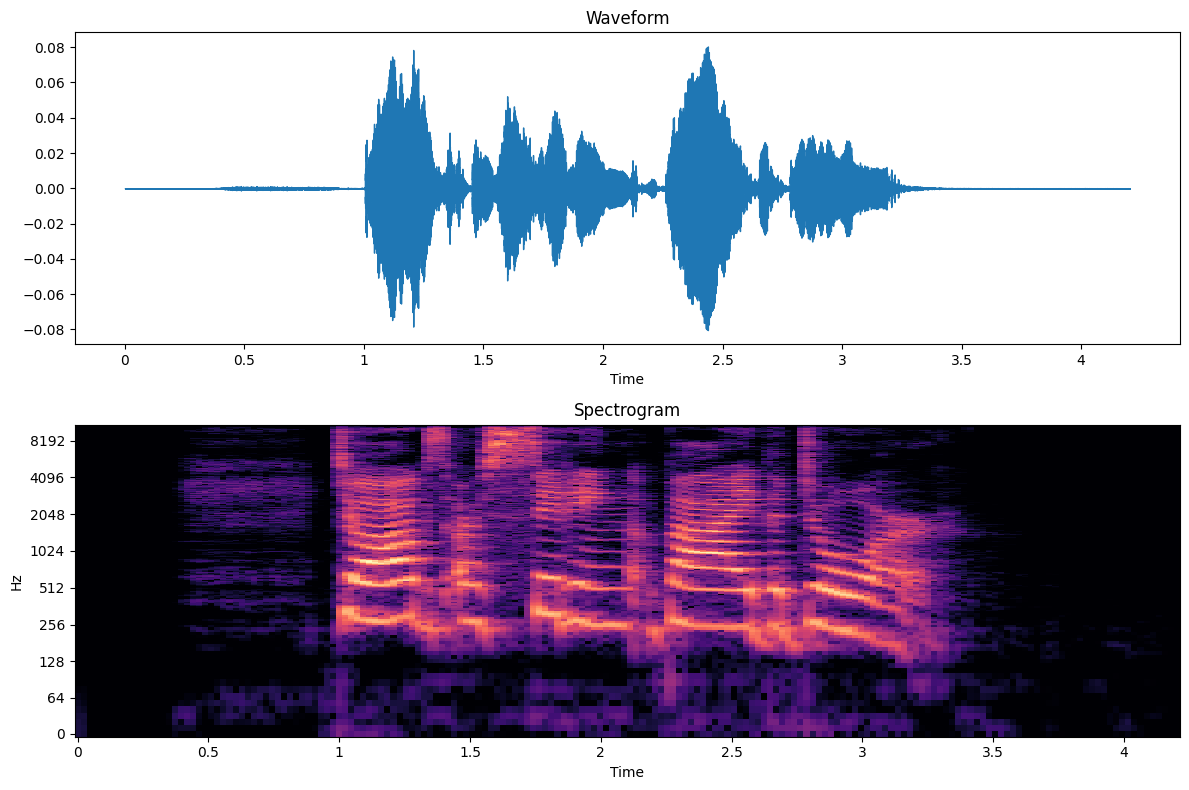

In [18]:
# Parse filenames to extract details
details = []
for file_path in file_paths:
    filename = os.path.basename(file_path)
    parts = filename.split('-')
    details.append({
        'Modality': parts[0],
        'Vocal Channel': parts[1],
        'Emotion': parts[2],
        'Emotional Intensity': parts[3],
        'Statement': parts[4],
        'Repetition': parts[5],
        'Actor': parts[6].split('.')[0],
    })

# Display a few sample details
for i in range(5):
    print(details[i])

# Plot waveform and spectrogram for a sample file
sample_file = file_paths[0]
y, sr = librosa.load(sample_file)
plt.figure(figsize=(12, 8))

# Waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

# Spectrogram
plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')

plt.tight_layout()
plt.show()

# Feature Extraction

In [19]:
import numpy as np

def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # Mel-frequency cepstral coefficients (MFCCs)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Chroma feature
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    # Mel-scaled spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)

    # Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)

    return np.hstack((mfccs, chroma, mel, contrast, tonnetz))

# Extract features for all files
features = np.array([extract_features(file_path) for file_path in file_paths])

# Print the shape of the feature matrix
print(f"Feature matrix shape: {features.shape}")

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


Feature matrix shape: (1440, 193)


Data Pre-Processing

Normalize

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels (emotion) to integers
labels = [detail['Emotion'] for detail in details]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1152, 193)
Test data shape: (288, 193)


# Model Building

Random Forest

Accuracy: 57.99%

Classification Report:
               precision    recall  f1-score   support

          01       0.60      0.12      0.21        24
          02       0.67      0.89      0.76        44
          03       0.53      0.40      0.46        40
          04       0.57      0.74      0.65        31
          05       0.73      0.63      0.68        35
          06       0.70      0.46      0.56        41
          07       0.41      0.53      0.46        38
          08       0.51      0.71      0.60        35

    accuracy                           0.58       288
   macro avg       0.59      0.56      0.55       288
weighted avg       0.59      0.58      0.56       288



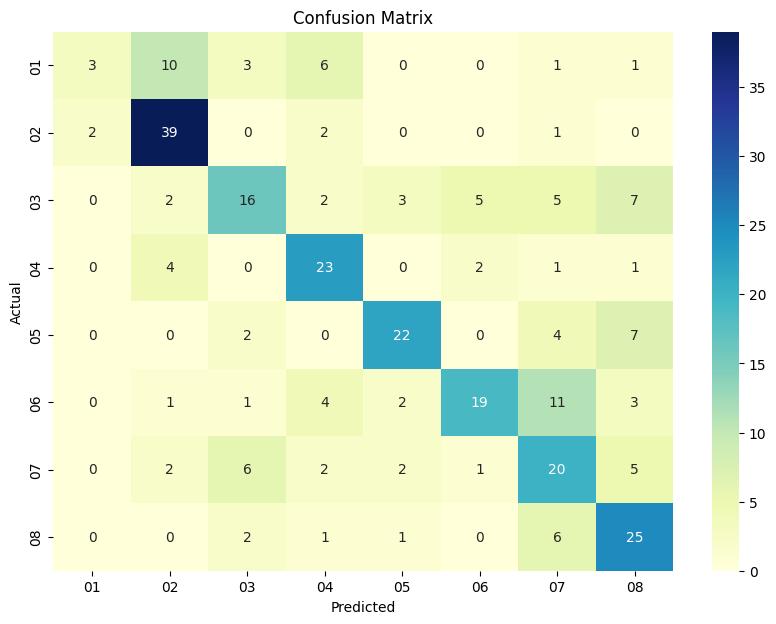

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Neural Net

Epoch 1/50
36/36 [==============================] - 1s 7ms/step - loss: 2.2868 - accuracy: 0.1832 - val_loss: 1.8911 - val_accuracy: 0.2708
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 1.9110 - accuracy: 0.2873 - val_loss: 1.7671 - val_accuracy: 0.3646
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 1.7738 - accuracy: 0.3325 - val_loss: 1.7953 - val_accuracy: 0.3854
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 1.7084 - accuracy: 0.3785 - val_loss: 1.6744 - val_accuracy: 0.4028
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 1.6218 - accuracy: 0.3880 - val_loss: 1.6265 - val_accuracy: 0.4375
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 1.5460 - accuracy: 0.4132 - val_loss: 1.5738 - val_accuracy: 0.4479
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 1.4892 - accuracy: 0.4514 - val_loss: 1.4940 - val_accuracy: 0.4583
Epoch 8/50
36/36 [==

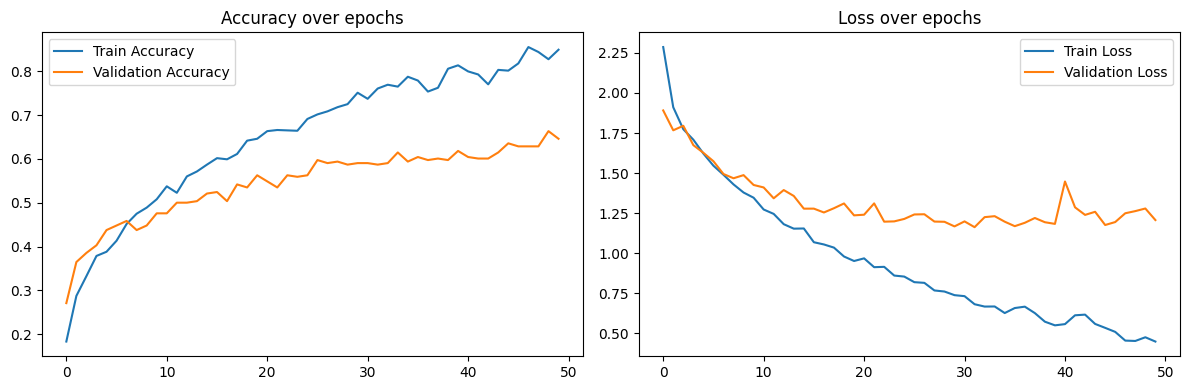

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Build the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(X_test, y_test_onehot))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.tight_layout()
plt.show()